In [9]:
import pandas as pd

final_dataset = pd.read_csv('mp1.csv')
test_dataset = pd.read_csv('m1_test.csv')
print(final_dataset)

        Store  Container_404  Bad_Subs  Manual_Pick
0       53223             63        27           82
1       24612             33        47          115
2       40717             69         5           61
3       77993             74        20          171
4       99213             27        28            1
...       ...            ...       ...          ...
119971  26396             36        25           17
119972  59132             75        19           32
119973  94912              4        16          186
119974  85080             57        28           23
119975  60365             19        28          136

[119976 rows x 4 columns]


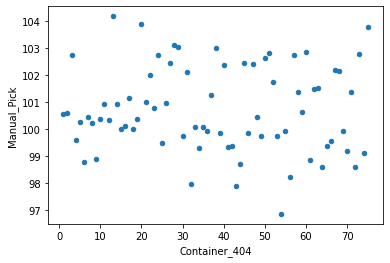

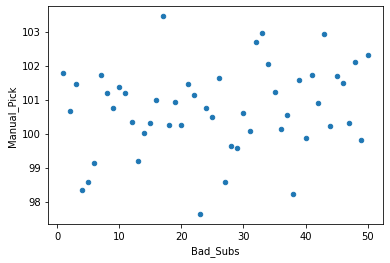

In [10]:
import matplotlib.pyplot as plt

plot_df = final_dataset[['Manual_Pick', 'Container_404']]
rounded_temp = plot_df['Container_404'].round(0)  # nearest integer
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Container_404', y='Manual_Pick')
plt.show()

plot_df = final_dataset[['Manual_Pick', 'Bad_Subs']]
rounded_temp = plot_df['Bad_Subs'].round(0)  # nearest integer
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Bad_Subs', y='Manual_Pick')
plt.show()

In [11]:
def split_train_eval(final_dataset):
    final_dataset = final_dataset.sample(frac=1)
    eval_size = len(final_dataset) // 10
    eval_set = final_dataset.iloc[:eval_size]
    train_set = final_dataset.iloc[eval_size:]
    return train_set, eval_set

def add_int_features(dataset_row, feature_dict, has_labels):
    int_vals = ['Store','Container_404','Bad_Subs']
    if has_labels:
        int_vals.append('Manual_Pick')
    for feature_name in int_vals:
        list_val = tf.train.Int64List(value=[dataset_row[feature_name]])
        feature_dict[feature_name] = tf.train.Feature(int64_list=list_val)

def create_example(dataset_row, has_labels):
    feature_dict = {}
    add_int_features(dataset_row, feature_dict, True)
    features_obj = tf.train.Features(feature=feature_dict)
    return tf.train.Example(features=features_obj)

In [12]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Write serialized Example objects to a TFRecords file
def write_tfrecords(dataset, has_labels, tfrecords_file):
    writer = tf.compat.v1.python_io.TFRecordWriter(tfrecords_file)
    for i in range(len(dataset)):
        example = create_example(dataset.iloc[i], has_labels)
        writer.write(example.SerializeToString())
    writer.close()



# train_set is the training DataFrame
write_tfrecords(split_train_eval(final_dataset)[0], True, 'train_manual_pick.tfrecords')

# eval_set is the evaluation DataFrame
write_tfrecords(split_train_eval(final_dataset)[1], True, 'eval_manual_pick.tfrecords')

# test_set is the test DataFrame
write_tfrecords(test_dataset, False, 'test_manual_pick.tfrecords')

Num GPUs Available:  0


In [13]:
import tensorflow as tf

# Create the spec used when parsing the Example object
def create_example_spec(has_labels):
    example_spec = {}
    int_vals = ['Store','Container_404','Bad_Subs']
    if has_labels:
        int_vals.append('Manual_Pick')
    for feature_name in int_vals:
        example_spec[feature_name] = tf.compat.v1.FixedLenFeature((), tf.int64)
    return example_spec

example_spec = create_example_spec(True)

# Helper function to convert serialized Example objects into features
def parse_features(ser_ex, example_spec, has_labels):
    parsed_features = tf.compat.v1.parse_single_example(ser_ex, example_spec)
    features = {k: parsed_features[k] for k in parsed_features if k != 'Manual_Pick'}
    if not has_labels:
        return features
    label = parsed_features['Manual_Pick']
    return features,label

def get_train_data():
    train_file = 'train_manual_pick.tfrecords'
    train_dataset = tf.data.TFRecordDataset(train_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    train_dataset = train_dataset.map(parse_fn)
    train_dataset = train_dataset.shuffle(100000)
    train_dataset = train_dataset.batch(1000)
    return train_dataset

def get_eval_data():
    eval_file = 'eval_manual_pick.tfrecords'
    eval_dataset = tf.data.TFRecordDataset(eval_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    eval_dataset = eval_dataset.map(parse_fn)
    eval_dataset = eval_dataset.shuffle(100000)
    eval_dataset = eval_dataset.batch(200)
    return eval_dataset

def get_test_data():
    test_file = 'test_manual_pick.tfrecords'
    test_dataset = tf.data.TFRecordDataset(eval_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    test_dataset = test_dataset.map(parse_fn)
    return test_dataset

In [14]:
import tensorflow as tf

def add_numeric_columns(feature_columns):
    numeric_features = ['Store','Container_404','Bad_Subs']
    for feature_name in numeric_features:
        feature_col = tf.feature_column.numeric_column(feature_name, shape=())
        feature_columns.append(feature_col)

def create_feature_columns():
    feature_columns = []
    add_numeric_columns(feature_columns)
    return feature_columns


In [15]:
class SubsModel(object):
  def __init__(self, hidden_layers):
    self.hidden_layers = hidden_layers
  
  def run_regression_predict(self, ckpt_dir, data_file):
    regression_model = self.create_regression_model(ckpt_dir)
    predictions = regression_model.predict(input_fn=get_test_data)
    print("Predictions ",predictions)
    pred_list = []
    for pred_dict in predictions:
        pred_list.append(pred_dict['predictions'][0])
    print(pred_list)
    return pred_list

  def run_regression_eval(self, ckpt_dir):
    regression_model = self.create_regression_model(ckpt_dir)
    return regression_model.evaluate(input_fn=get_eval_data)

  def run_regression_training(self, ckpt_dir, batch_size, num_training_steps=None):
    regression_model = self.create_regression_model(ckpt_dir)
    regression_model.train(input_fn=get_train_data, steps=num_training_steps)

  def create_regression_model(self, ckpt_dir):
    config = tf.estimator.RunConfig(log_step_count_steps=5000)
    regression_model = tf.estimator.Estimator(
      self.regression_fn,
      config=config,
      model_dir=ckpt_dir)
    return regression_model

  def regression_fn(self, features, labels, mode, params):
    feature_columns = create_feature_columns()
    inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
    batch_predictions = self.model_layers(inputs) 
    predictions = tf.squeeze(batch_predictions)
    if labels is not None:
        loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.compat.v1.train.get_or_create_global_step()
        adam = tf.compat.v1.train.AdamOptimizer()
        train_op = adam.minimize(
        loss, global_step=global_step)
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)
    if mode == tf.estimator.ModeKeys.PREDICT:
        prediction_info = {
          'predictions': batch_predictions
        }
    return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)

  def model_layers(self, inputs):
    layer = inputs
    for num_nodes in self.hidden_layers:
        layer = tf.compat.v1.layers.dense(layer, num_nodes,
        activation=tf.nn.relu)
    batch_predictions = tf.compat.v1.layers.dense(layer, 1)
    return batch_predictions

In [16]:
subs_model = SubsModel([500,100])
count = 100000
for i in range(count):
    subs_model.run_regression_training(ckpt_dir="/tmp/test_manual_pick_2", batch_size=5000)
subs_model.run_regression_eval(ckpt_dir="/tmp/test_manual_pick_2")
#subs_model.run_regression_predict(ckpt_dir="/tmp/test_manual_pick", data_file="train_manual_pick.tfrecords")
print("Done")

INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was fina

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick_2/model.ckpt-432
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 432...
INFO:tensorflow:Saving checkpoints for 432 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 432...
INFO:tensorflow:loss = 62.409412, step = 432
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540...
INFO:tensorflow:Saving checkpoints for 540 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540...
INFO:tensorflow:Loss for final step: 503.54657.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick_2', '_tf_random_seed': None, '_save_summary_ste

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 864...
INFO:tensorflow:Saving checkpoints for 864 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 864...
INFO:tensorflow:loss = 91.66291, step = 864
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 972...
INFO:tensorflow:Saving checkpoints for 972 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 972...
INFO:tensorflow:Loss for final step: 98.419395.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_st

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1404...
INFO:tensorflow:Loss for final step: 302.87567.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Callin

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick_2/model.ckpt-1836
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1836...
INFO:tensorflow:Saving checkpoints for 1836 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1836...
INFO:tensorflow:loss = 55.15021, step = 1836
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1944...
INFO:tensorflow:Saving checkpoints for 1944 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1944...
INFO:tensorflow:Loss for final step: 66.673386.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick_2', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2268...
INFO:tensorflow:Saving checkpoints for 2268 into /tmp/test_manual_pick_2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2268...


KeyboardInterrupt: 